Some cells are the same as the tutorial's cells. Howerver, Here we use English-Persian set.

Tutorial:
https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [7]:
import io, os
import time
import unicodedata
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Download Data

http://www.manythings.org/anki/

In [8]:
!wget http://www.manythings.org/anki/pes-eng.zip
!unzip pes-eng.zip

--2021-02-01 08:47:55--  http://www.manythings.org/anki/pes-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112927 (110K) [application/zip]
Saving to: ‘pes-eng.zip.1’

pes-eng.zip.1       100%[===================>] 110.28K   465KB/s    in 0.2s    

2021-02-01 08:47:56 (465 KB/s) - ‘pes-eng.zip.1’ saved [112927/112927]

Archive:  pes-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              
replace pes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: pes.txt                 


# Process data

In [9]:
path_to_file = "pes.txt"

In [10]:
# the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


# this function preprocess the English Sentences
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


# this function preprocess the Persian Sentences
def preprocess_sentence_per(w):
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w =  '<end> ' + w + ' <start>' 
  return w

In [11]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: ENGLISH, PERSIAN

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_examples]]

  english = []
  persian = []

  for i in range(len(word_pairs)):
    english.append(preprocess_sentence(word_pairs[i][0]))
    persian.append(preprocess_sentence_per(word_pairs[i][1]))
  

  return english, persian

In [12]:
en, per = create_dataset(path_to_file, None)
print(en[-1])
print(per[-1])

<start> don t lend books no one gives them back . the only books that are still left in my library are ones that i have borrowed from other people . <end>
<end> کتاب‌ها را امانت ندهید؛ هیچکس آنها را پس نمی‌دهد . تنها کتابهایی که هنوز در کتابخانهٔ من باقی مانده‌اند، آنهایی هستند که از دیگران به امانت گرفته‌ام .  <start>


In [13]:
for i in range(8, 10):
  print(en[i])
  print(per[i], '\n')

<start> really ? <end>
<end> جدا؟ <start> 

<start> why me ? <end>
<end> چرا من؟ <start> 



In [14]:
for i in range(28, 34):
  print(en[i])
  print(per[i], '\n')

<start> welcome . <end>
<end> خوش آمدید .  <start> 

<start> get away ! <end>
<end> دور شو !  <start> 

<start> good job ! <end>
<end> ایوَل !  <start> 

<start> good job ! <end>
<end> خسته نباشی !  <start> 

<start> grab him . <end>
<end> دستگیرش کن .  <start> 

<start> hurry up . <end>
<end> عجله کن !  <start> 



In [15]:
len(en)

2284

In [16]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [17]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [18]:
num_examples = 2275
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [19]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1820 1820 455 455


In [20]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [21]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <end>
214 ----> تصمیم
225 ----> گرفتم
1735 ----> بوباره
198 ----> سعی
26 ----> کنم
3 ----> .
2 ----> <start>

Target Language; index to word mapping
1 ----> <start>
5 ----> i
310 ----> decided
6 ----> to
336 ----> try
136 ----> again
3 ----> .
2 ----> <end>


Create a tf.data dataset

In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 2048

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
print('vocab size of input language: ', vocab_inp_size)
print('vocab size of target language: ', vocab_tar_size )

vocab size of input language:  3743
vocab size of target language:  2503


In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 27]), TensorShape([128, 27]))

# The encoder and decoder model

**Encoder**

In [25]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
  
    self.gru_1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=False,
                                   recurrent_initializer='glorot_uniform')
    
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    #self.bidirectional = tf.keras.layers.Bidirectional(self.gru)

  def call(self, x, hidden):
    x = self.embedding(x)
    #output, state = self.bidirectional(self.gru(x, initial_state = hidden))
    x = self.gru_1(x, initial_state = hidden)
    output, state = self.gru(x)
    
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input and
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 27, 2048)
Encoder Hidden state shape: (batch size, units) (128, 2048)


In [27]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1916416   
_________________________________________________________________
gru (GRU)                    multiple                  15740928  
_________________________________________________________________
gru_1 (GRU)                  multiple                  25178112  
Total params: 42,835,456
Trainable params: 42,835,456
Non-trainable params: 0
_________________________________________________________________


**Attention**

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (128, 27, 1)


**Decoder**

In [29]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.gru_1 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=False,
                                   recurrent_initializer='glorot_uniform')
    
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    x = self.gru_1(x)
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [30]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

decoder.summary()

Decoder output shape: (batch_size, vocab size) (128, 2503)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1281536   
_________________________________________________________________
gru_2 (GRU)                  multiple                  28323840  
_________________________________________________________________
gru_3 (GRU)                  multiple                  25178112  
_________________________________________________________________
dense_3 (Dense)              multiple                  5128647   
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  8394753   
Total params: 68,306,888
Trainable params: 68,306,888
Non-trainable params: 0
_________________________________________________________________


# Optimizer and loss function

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

saving checkpoints

In [32]:
checkpoint_dir = './training_translation_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Train

In [33]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [34]:
EPOCHS = 8 #10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6605
Epoch 1 Loss 2.3945
Time taken for 1 epoch 59.452446699142456 sec

Epoch 2 Batch 0 Loss 2.0062
Epoch 2 Loss 1.7585
Time taken for 1 epoch 16.991777420043945 sec

Epoch 3 Batch 0 Loss 1.6738
Epoch 3 Loss 1.6044
Time taken for 1 epoch 12.1823251247406 sec

Epoch 4 Batch 0 Loss 1.5440
Epoch 4 Loss 1.5254
Time taken for 1 epoch 16.628241300582886 sec

Epoch 5 Batch 0 Loss 1.4899
Epoch 5 Loss 1.4728
Time taken for 1 epoch 12.156871557235718 sec

Epoch 6 Batch 0 Loss 1.4721
Epoch 6 Loss 1.4256
Time taken for 1 epoch 16.765195846557617 sec

Epoch 7 Batch 0 Loss 1.3595
Epoch 7 Loss 1.3901
Time taken for 1 epoch 12.206277132034302 sec

Epoch 8 Batch 0 Loss 1.2849
Epoch 8 Loss 1.3489
Time taken for 1 epoch 16.60757064819336 sec



# Evaluate the model

In [35]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence_per(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [36]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [37]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <end> زنده باشی <start>
Predicted translation: i want to the good <end> 


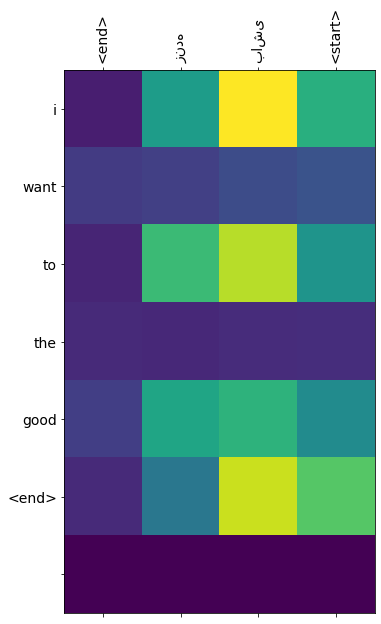

In [39]:
translate('زنده باشی')

Input: <end> حال شما چطور است <start>
Predicted translation: i want to the book . <end> 


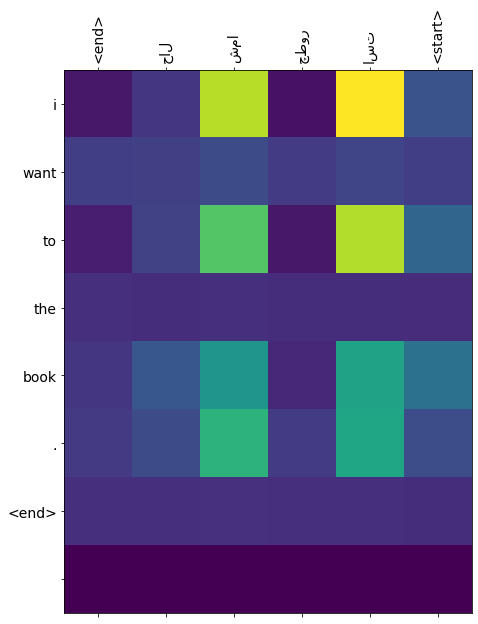

In [40]:
translate('حال شما چطور است')

Input: <end> من شما را نمی شناسم <start>
Predicted translation: i want to the book . <end> 


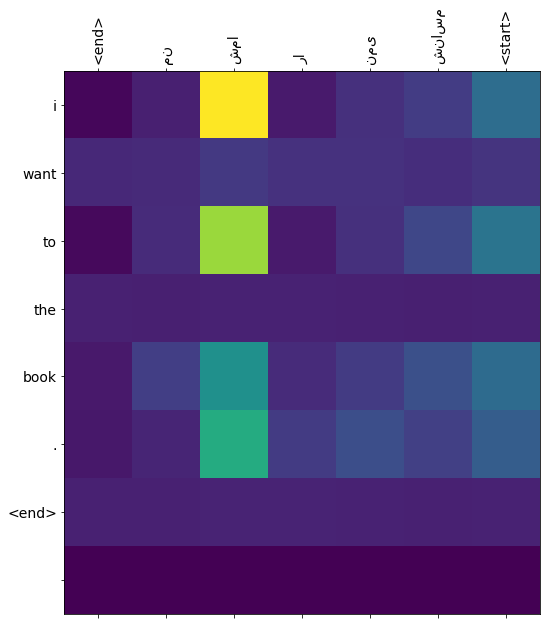

In [41]:
translate('من شما را نمی شناسم')

Input: <end> خوبی <start>
Predicted translation: i want to the same clock . <end> 


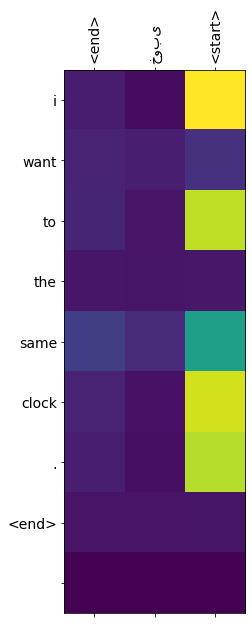

In [42]:
translate('خوبی')

Input: <end> زن ها خوب هستند <start>
Predicted translation: i ll be . <end> 


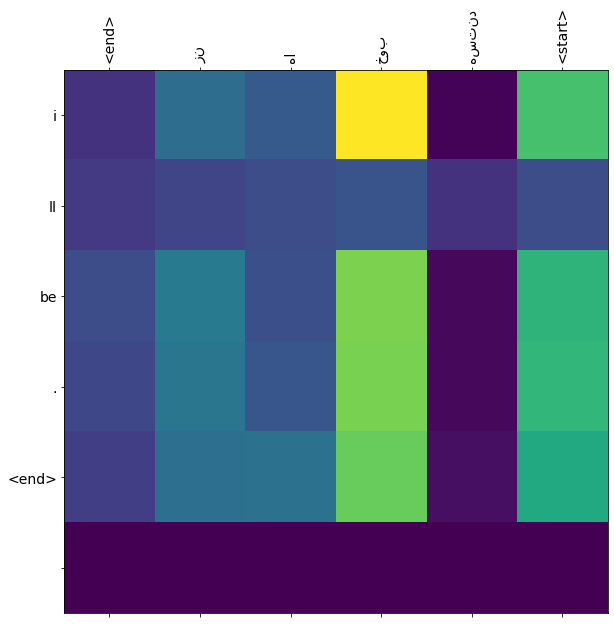

In [43]:
translate('زن ها خوب هستند')

Input: <end> مرد ها خوب هستند <start>
Predicted translation: i ll be . <end> 


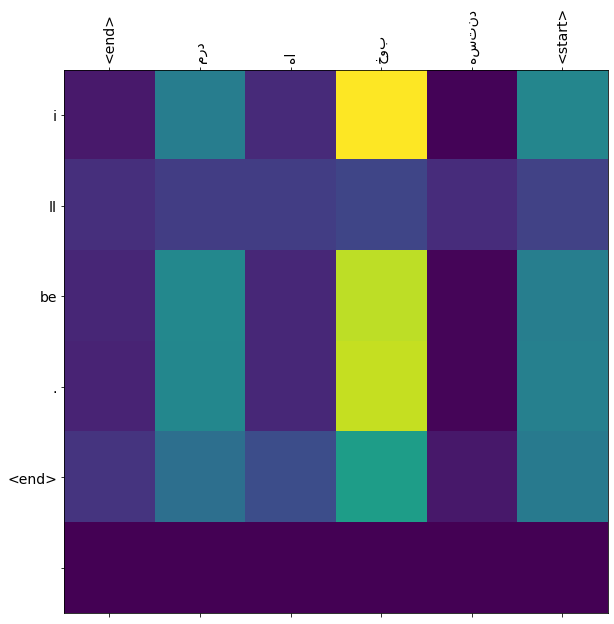

In [44]:
translate('مرد ها خوب هستند')

In [45]:
translate('نام شما چیست')

KeyError: ignored

Input: <end> نام شما چه است <start>
Predicted translation: i don t go . <end> 


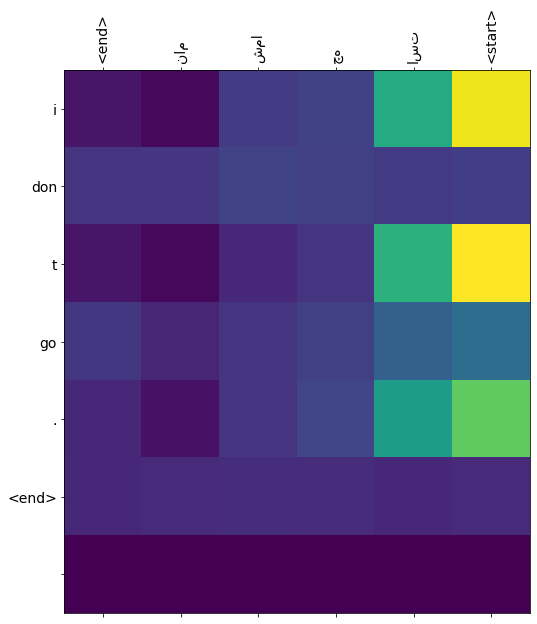

In [46]:
translate('نام شما چه است')

Input: <end> شغل <start>
Predicted translation: i don t go . <end> 


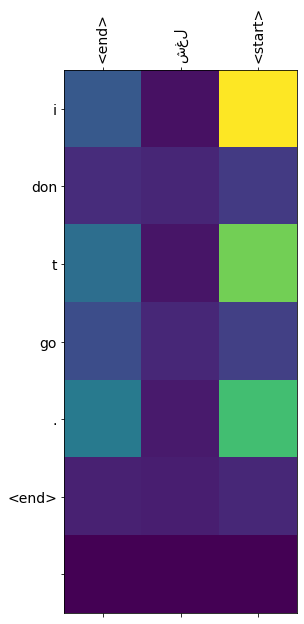

In [47]:
translate('شغل')

Input: <end> ترجمه کن <start>
Predicted translation: i want to the good <end> 


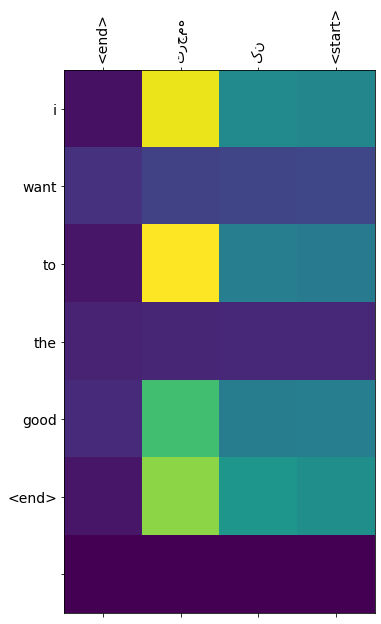

In [48]:
translate('ترجمه کن')

In [ ]:
translate('نام خانواده')

Input: <end> من دانش جو هستم <start>
Predicted translation: i don t go . <end> 


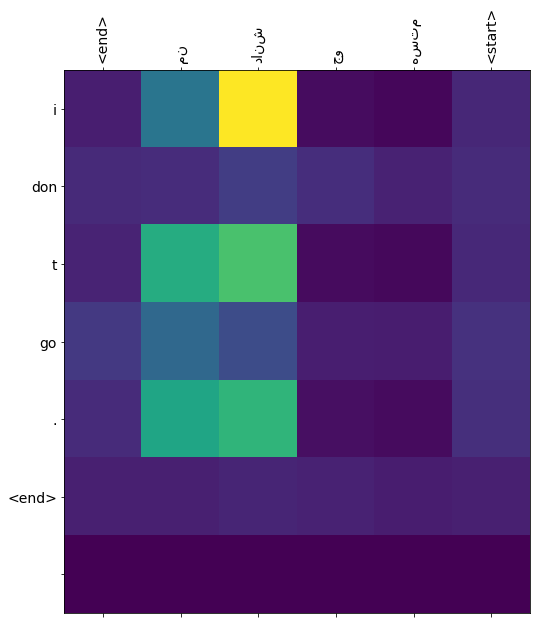

In [51]:
translate('من دانش جو هستم')

Input: <end> چرا <start>
Predicted translation: i want to the good mother a book . <end> 


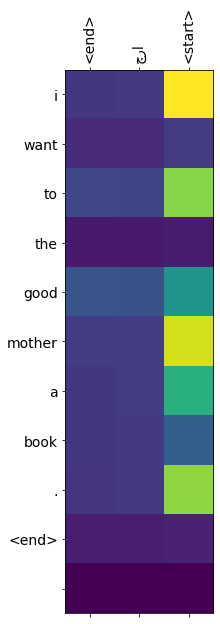

In [50]:
translate('چرا')

Input: <end> دکتر ها بسیار مشغول هستند <start>
Predicted translation: i ll be time . <end> 


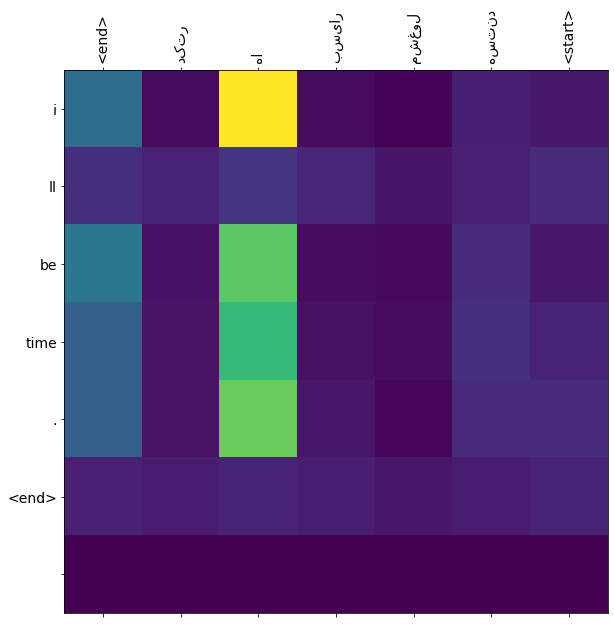

In [52]:
translate('دکتر ها بسیار مشغول هستند')

Input: <end> دستگیرش کن <start>
Predicted translation: i don t go . <end> 


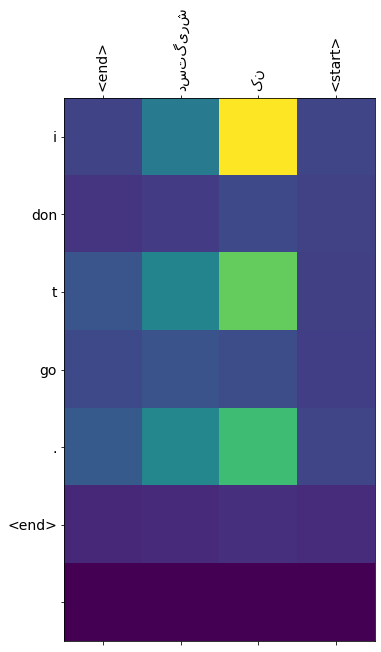

In [54]:
translate('دستگیرش کن')

Input: <end> خوب هست <start>
Predicted translation: i want to the good <end> 


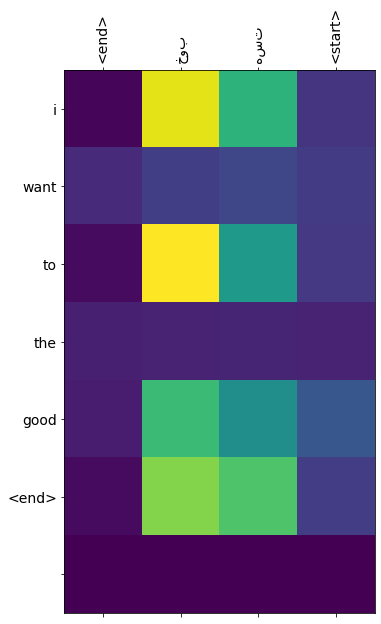

In [53]:
 translate('خوب هست')

Input: <end> آن خانه را نگاه کن <start>
Predicted translation: i don t go . <end> 


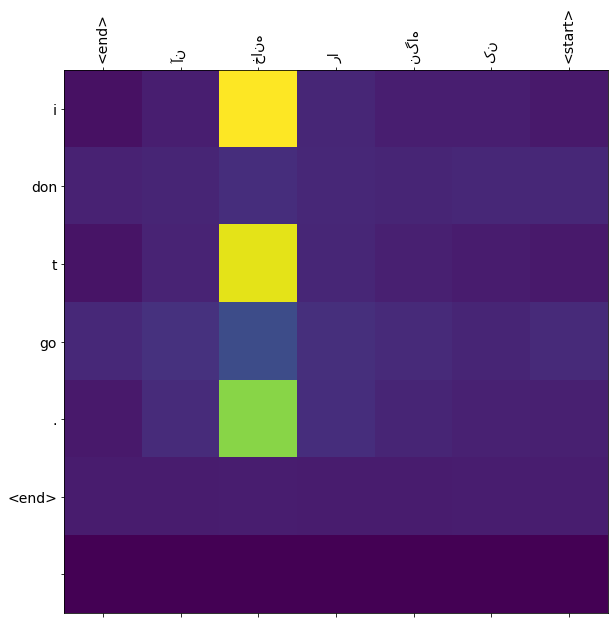

In [55]:
 translate('آن خانه را نگاه کن')